In [31]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from warnings import filterwarnings

# Task 3 - Regression 

## Load settings

In [13]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task3"
#filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"
filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [14]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],
    },{
        'clf':[RandomForestRegressor(random_state=seed)],  
        'clf__n_estimators':[100,150,200],
        
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [15]:
filename = "datasets/powerTrainData.mat"

mat = loadmat(filename)
input_train = mat['powerTrainInput'].T

target_train = mat['powerTrainOutput'].reshape(len(input_train))
input_test = mat['powerTestInput'].T

## Data info

In [16]:
get_data_info(input_train, target_train)

Length of 844
X.shape: (844, 15) y.shape: (844,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[ 3.2400e+03  2.5467e+03  2.4383e+03  3.2400e+03  3.2400e+03  4.5000e+01
   3.7000e+01  4.4040e+01  4.6760e+01  2.6480e+01  1.0780e+01  3.9170e+01
   8.1400e+00  9.8200e-01  1.8800e-01]
 [ 1.8710e+03  1.7938e+03  1.7097e+03  2.0940e+03  2.0940e+03  6.1000e+01
   5.7000e+01  6.6670e+01  6.5480e+01  5.2670e+01  4.8920e+01  7.0000e+01
   7.2260e+01 -9.1200e-01 -4.0900e-01]] 
Target: [3359 1868]


## Preprocess
Normalize the dataset

In [17]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

844


## Feature reduction
Reduce dimensionality by PCA transform

In [18]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (844, 15)
transformed shape: (844, 6)
Explained variance: [0.71291343 0.08305948 0.06661705 0.04012179 0.03533515 0.02463563]


# Feature extraction

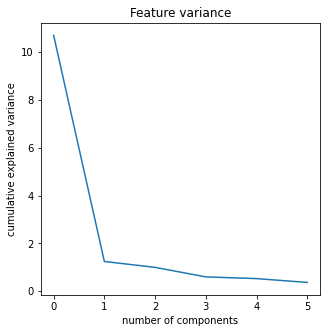

In [19]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

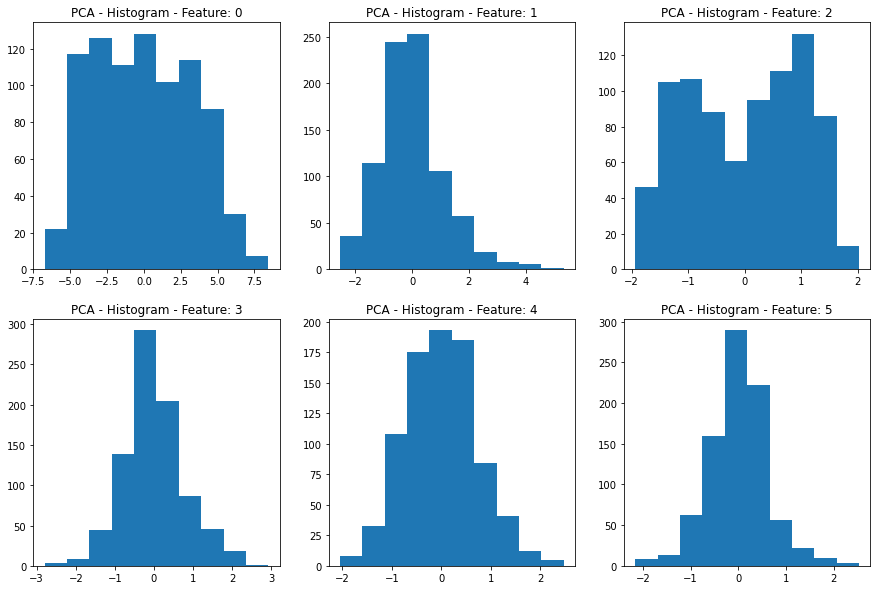

In [20]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(844, 15)


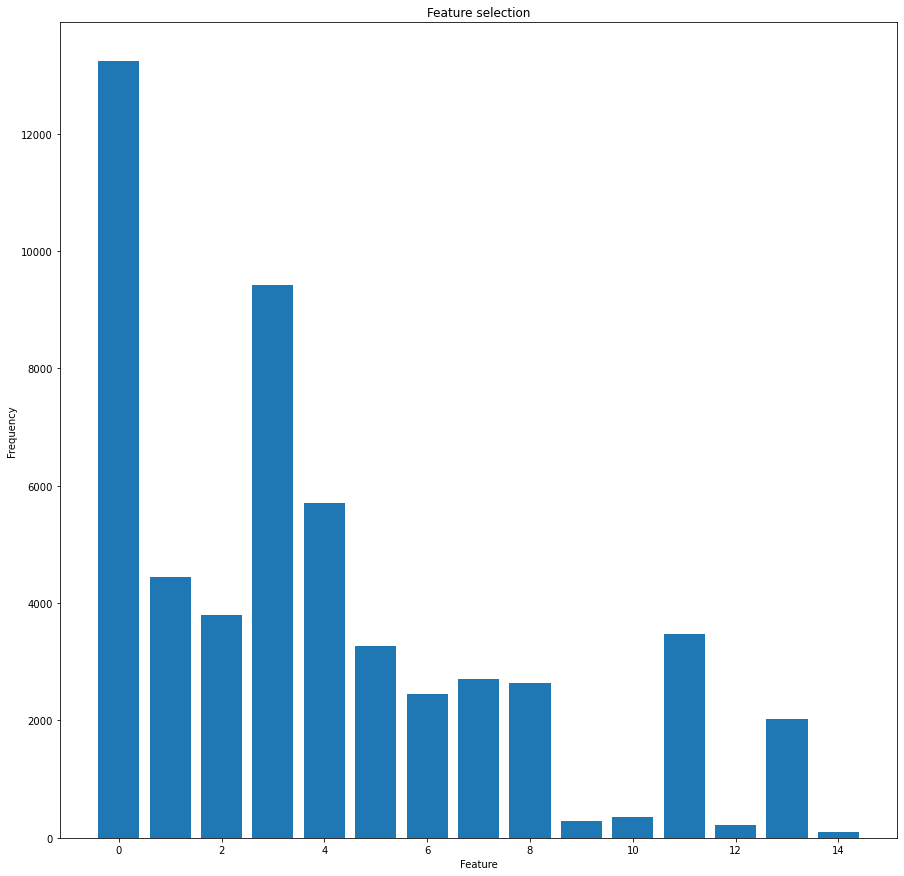

In [21]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname, feature_tot=feature_tot)

## Hyperparameter tuning

In [22]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.9min finished


## Save model

In [23]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/Models/task3.joblib


## Load model

In [24]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [25]:
get_model_info(grid)

Best score: -10809.330863491137
Best params {'clf': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 20), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False), 'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__early_stopping': False, 'clf__hidden_layer_sizes': (100, 20), 'clf__max_iter': 200, 'clf__solver': 'lbfgs'}

                                                                                                                                                                                                                                                                     

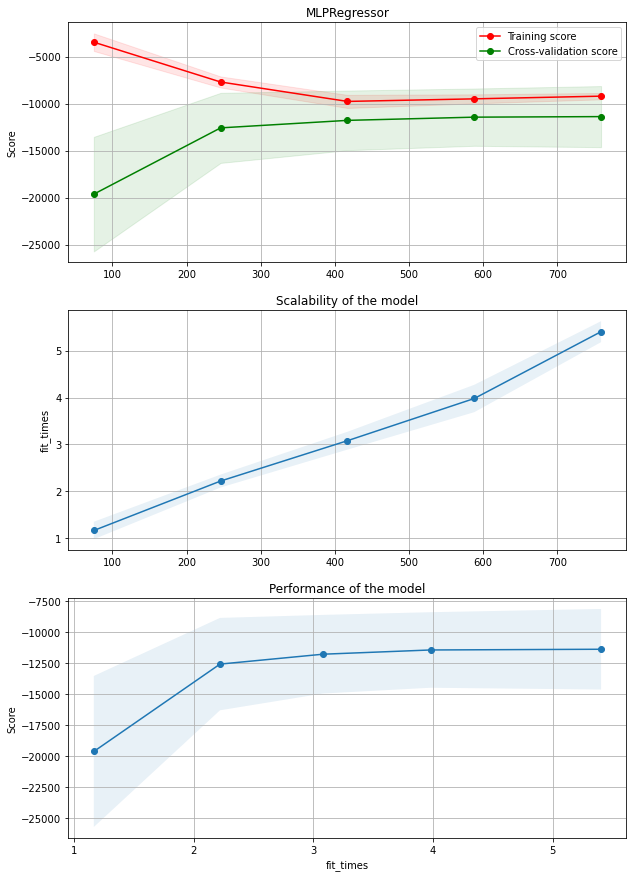

In [26]:
validate_curve(grid, input_train_fs, target_train,filedir=filedir, taskname=taskname, scoring=scoring, k=k)

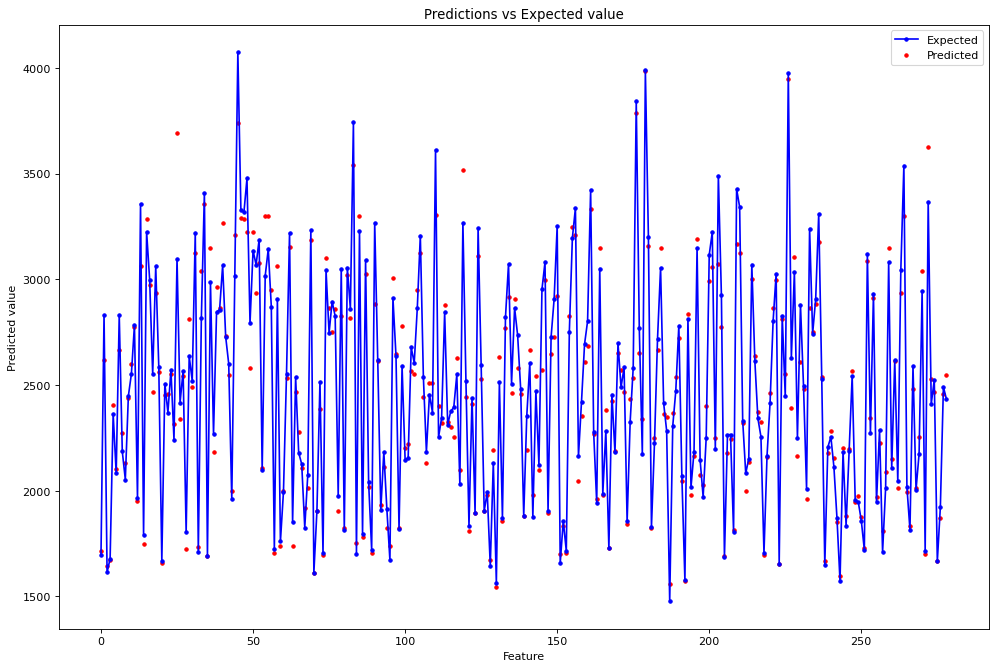

In [27]:
display_model_predict(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [32]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[3211.64622907 3077.30567909 3229.69254198 3126.27616481 2849.02420705
 2516.56426663 2403.30640483 3368.61365835 3113.03363071 3328.00439794
 3208.93821961 3373.82534541 2957.4073392  2879.3352444  2438.52540089
 3150.97161577 3257.61826741 3173.81934812 2717.25432948 3286.34238882
 2892.67503732 3073.86233603 3224.093171   3257.52890323 2962.28463836
 3132.88637416 3485.8058193  2367.86799034 3167.39302726 3261.69042105
 3631.33469187 2901.90960757 3105.83685593 3849.83627414 3423.25529007
 3126.19799997 3353.92548832 2799.27149771 3126.22869628 2888.36204565
 2633.30270479 3441.64871976 3070.58743901 3355.09548083 3508.35394836
 3052.88095664 2547.73783137 2797.82144462 2858.27980048 2371.68961216
 3117.79285693 3396.537706   3071.12366301 2481.34693078 2926.73716745
 3125.58732289 2609.58025819 3256.35811274 3419.53701104 3125.11774525
 3122.10084529 3650.88052824 2935.86216573 3087.93780199 3716.4306982
 3341.32475955 3215.40185404 3149.63775022 2940.86610836 3280.38344934
 2545.6